In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [12]:
import os
import shutil
import random

def split_dataset(original_dataset_dir, train_dir, val_dir, test_dir, split_ratio=(0.7, 0.15, 0.15)):
    classes = os.listdir(original_dataset_dir)  # List all classes

    for class_name in classes:
        class_path = os.path.join(original_dataset_dir, class_name)
        images = os.listdir(class_path)
        random.shuffle(images)  # Shuffle to ensure randomness

        train_size = int(split_ratio[0] * len(images))
        val_size = int(split_ratio[1] * len(images))

        # Split into train, validation, and test sets
        train_images = images[:train_size]
        val_images = images[train_size:train_size + val_size]
        test_images = images[train_size + val_size:]

        # Create destination folders
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

        # Move files to respective folders
        for img in train_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))
        for img in val_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, class_name, img))
        for img in test_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_name, img))

# Usage
split_dataset(
    original_dataset_dir='dataset/villagedataset',  # Source folder
    train_dir='dataset/train',
    val_dir='dataset/validation',
    test_dir='dataset/test'
)

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation for Training
train_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=30, width_shift_range=0.2,
    height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)  # Just rescaling for validation/test

# Load images from dataset directories
train_generator = train_datagen.flow_from_directory(
    'dataset/train',
    target_size=(150, 150), batch_size=32, class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    'dataset/validation',
    target_size=(150, 150), batch_size=32, class_mode='categorical'
)

Found 37997 images belonging to 38 classes.
Found 8129 images belonging to 38 classes.


In [15]:
# Define the CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),  # Flatten the feature maps to feed into Dense layers
    Dense(512, activation='relu'),
    Dropout(0.5),  # Regularization to prevent overfitting
    Dense(train_generator.num_classes, activation='softmax')  # Output layer
])

# Compile the Model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Model Summary
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 38)             │        19,494 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,053,158 (72.68 MB)

 Trainable params: 19,053,158 (72.68 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/10
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.3709 - loss: 2.3360

c:\Users\goyal\miniconda3\envs\DL\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1187/1187 ━━━━━━━━━━━━━━━━━━━━ 705s 593ms/step - accuracy: 0.3710 - loss: 2.3355 - val_accuracy: 0.7077 - val_loss: 0.9343
Epoch 2/10
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 0s 55us/step - accuracy: 0.6250 - loss: 1.1729 - val_accuracy: 1.0000 - val_loss: 4.3550e-04
Epoch 3/10


c:\Users\goyal\miniconda3\envs\DL\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


1187/1187 ━━━━━━━━━━━━━━━━━━━━ 785s 662ms/step - accuracy: 0.6725 - loss: 1.0690 - val_accuracy: 0.7436 - val_loss: 0.8472
Epoch 4/10
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 0s 32us/step - accuracy: 0.6875 - loss: 0.8313 - val_accuracy: 1.0000 - val_loss: 5.0543e-05
Epoch 5/10
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 819s 690ms/step - accuracy: 0.7621 - loss: 0.7637 - val_accuracy: 0.7926 - val_loss: 0.6508
Epoch 6/10
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 0s 34us/step - accuracy: 0.8438 - loss: 0.6843 - val_accuracy: 1.0000 - val_loss: 9.8943e-06
Epoch 7/10
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 745s 628ms/step - accuracy: 0.8056 - loss: 0.6220 - val_accuracy: 0.8415 - val_loss: 0.5316
Epoch 8/10
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 0s 35us/step - accuracy: 0.7812 - loss: 0.6300 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 9/10
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 705s 593ms/step - accuracy: 0.8286 - loss: 0.5495 - val_accuracy: 0.8574 - val_loss: 0.4354
Epoch 10/10
1187/1187 ━━━━━━━━━━━━━━━━━━━━ 0s 35us/step - accuracy: 0.

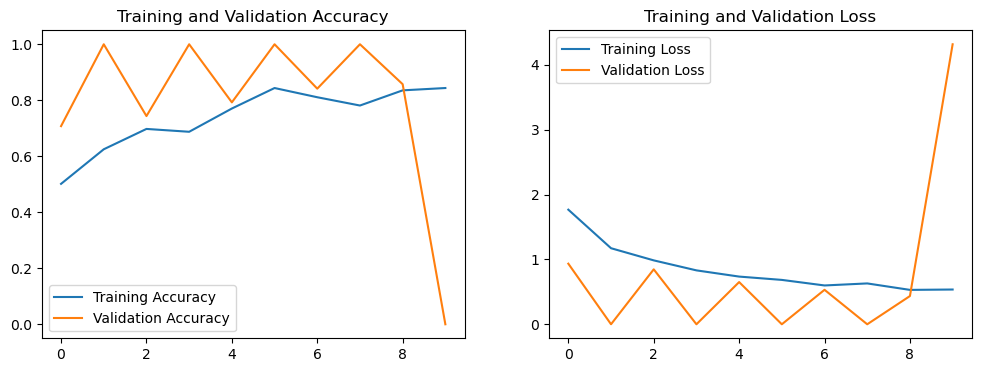

In [27]:
# Plot Training and Validation Accuracy and Loss
plt.figure(figsize=(12, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [28]:
test_generator = test_datagen.flow_from_directory(
    'dataset/test',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Found 8179 images belonging to 38 classes.
256/256 ━━━━━━━━━━━━━━━━━━━━ 28s 107ms/step - accuracy: 0.8636 - loss: 0.4203
Test Accuracy: 86.28%


In [105]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def predict_image(image_path):
    img = load_img(image_path, target_size=(150, 150))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Expand dims for batch size

    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction, axis=1)[0]  # Get the index of the highest probability

    # You can map the class index to class names if you have them
    class_names = list(train_generator.class_indices.keys())  # Assuming you have class indices from the training generator
    predicted_class_name = class_names[predicted_class_index]

    print(f"Predicted class: {predicted_class_name}")

# Example prediction
predict_image('image2.jpg')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted class: Pepper,_bell___Bacterial_spot
